## Installing the necessary libraries 

In [ ]:
%pip install langchain openai faiss-cpu tiktoken

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
#from dotenv import load_dotenv
from langchain.document_loaders import TextLoader
import faiss

# Reading the data 
-  Code to split the large dataset into chunks to optimize the running of the model. The chunks were then preprocessed without changing the essence of the orginal dataset

In [ ]:
import os
import nltk
import random
"""
  Code to split the large dataset into chunks to optimize the running of the model.
  The chunks were then preprocessed without changing the essence of the orginal dataset
"""
nltk.download('punkt')

def read_sentences_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    sentences = nltk.sent_tokenize(text)
    return sentences

def split_into_chunks(sentences, chunk_size=12):
    chunks = [sentences[i:i + chunk_size] for i in range(0, len(sentences), chunk_size)]
    return chunks

def write_chunks_to_file(chunks, output_file='nlpProject.txt'):
    with open(output_file, 'w', encoding='utf-8') as output:
        for chunk in chunks:
            output.write('\n'.join(chunk))
            output.write("\n\n")


file_path = '/content/data.txt'

all_sentences = read_sentences_from_file(file_path)


chunks = split_into_chunks(all_sentences, chunk_size=12)

random_selected_chunks = random.sample(chunks, min(1500, len(chunks)))

write_chunks_to_file(random_selected_chunks)

## Configuring the chatbot using LangChain 
- Setting up the chatbot to training on the customized vector db

In [5]:
import os
os.environ['OPENAI_API_KEY'] = ""
embeddings = OpenAIEmbeddings()

stories=[]

def create_custom_embeddings(path: str) -> FAISS:
    loader = TextLoader(path)
    documents= loader.load()

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
    docs = text_splitter.split_documents(documents)

    db = FAISS.from_documents(docs, embeddings)
    return db

#db=create_custom_embeddings('/Users/harisha/Downloads/nlpProject 2.txt')
#db.save_local("faiss_index")

#faiss.write_index(db, '/Users/harisha/Downloads/')


def get_response_from_query(db, query, k=4):

    docs = db.similarity_search(query, k=k)
    docs_page_content = " ".join([d.page_content for d in docs])

    llm = OpenAI(model_name="text-davinci-003")

    prompt = PromptTemplate(
        input_variables=["question", "docs"],
        template="""
        You are a children story telling assistant that that can generate stories based of a word or sentence

        Generate stories based on the following user input: {question}
        By searching the following documents: {docs}

        Your answers should be creative and detailed and kid freindly.
        """,
    )

    chain = LLMChain(llm=llm, prompt=prompt)

    response = chain.run(question=query, docs=docs_page_content)
    response = response.replace("\n", "")
    return response



## Installing the required libraries for the image pipeline 

In [ ]:
%pip install --upgrade pip
%pip install --upgrade diffusers transformers accelerate peft


## Creating a text to image model 
- The model takes in text from above to generate a story. The text is first summarized and then passed on to this model to generate the apt image 

In [ ]:
import torch
from diffusers import LCMScheduler, AutoPipelineForText2Image

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
adapter_id = "latent-consistency/lcm-lora-sdxl"

pipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

# load and fuse lcm lora
pipe.load_lora_weights(adapter_id)
pipe.fuse_lora()

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Falconsai/text_summarization")



## Formatting the story 

In [8]:
import textwrap
import matplotlib.pyplot as plt
def childeren_story_generation(query):
  new_db = FAISS.load_local("/content/drive/MyDrive/faiss_index", embeddings)
  response=get_response_from_query(new_db,query)
  print('\n---------------STORY----------------------\n')
  print(textwrap.fill(response, 40))
  print('\n---------------END OF STORY----------------\n')
  summarized_text = summarizer(response, max_length=70, min_length=50, do_sample=False)
  prompt = summarized_text[0]['summary_text']
  image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0).images[0]
  plt.imshow(image)


## Example output


---------------STORY----------------------

Once upon a time there was a beautiful
Princess who lived in a castle far away.
She was beloved by all who met her, for
she was kind, gentle and wise. But one
day, her kingdom was threatened by a
powerful sorcerer who wanted to take
control. The Princess was determined to
protect her people and so she set off on
a journey to find a way to defeat
him.Along the way, she encountered many
strange and wonderful creatures, from
talking animals to magical fairies. She
also discovered a magical sword that
could help her in her battle against the
sorcerer. With this sword, she was able
to fight off all the evil creatures that
stood in her way.Finally, the Princess
reached the sorcerer's castle and faced
him in a fierce battle. With her magical
sword, she was able to defeat the
sorcerer and save her kingdom from his
evil rule. The people of the kingdom
rejoiced and crowned the Princess their
new Queen.The Princess ruled her kingdom
with kindness and w

  0%|          | 0/4 [00:00<?, ?it/s]

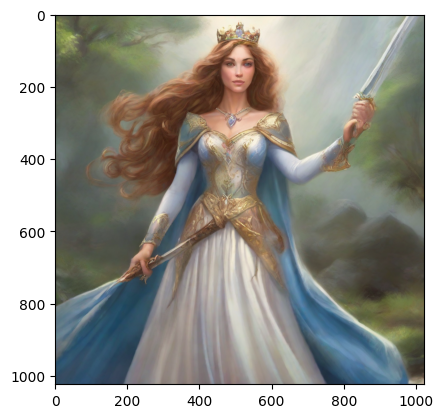

In [11]:
childeren_story_generation("Generate a story about a princess")